[ 12.37758127  11.43871218  11.50614603 ...  -1.55744351  -5.12504431
 -10.70069101]
[1.94791543 1.01082161 1.06319637 ... 0.80964068 0.53965375 0.06545648]
[ 1.74185865  0.83531553  0.85836525 ...  0.35832698  0.20647857
 -0.40633055]
[ 1.73729331  0.78176334  0.82179803 ...  0.24381041  0.08068489
 -0.28859938]
[ 1.96775068  1.01759441  1.06101408 ...  0.60869924  0.52341776
 -0.07627266]
[ 31.30278997  30.38385699  30.42727232 ...   0.7396042   -5.76768006
 -29.61629077]


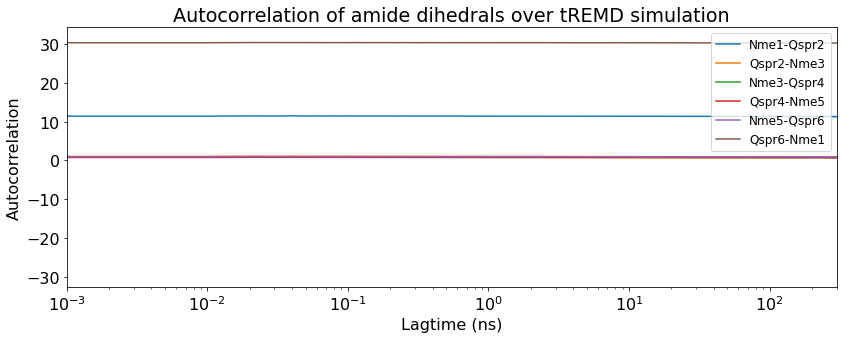

In [31]:
from pandas.plotting import autocorrelation_plot
import numpy as np
import tqdm
from matplotlib import pyplot as plt

if 1: # compute autocorrelation curve and relaxation time for each dihedral
    plt.figure(figsize=(12,5))
    for residue in range(6):
        autocorrelation = np.load(f'omega_data/pandas_autocorr_res_{residue}.npy')
        #print(autocorrelation)
        timesteps = np.arange(0, len(autocorrelation))*0.010
        #ax[residue].scatter(timesteps,autocorrelation, s=2)
        plt.scatter(timesteps,autocorrelation, s=2)
        print(sum([timesteps[x]*autocorrelation[x] for x in range(len(autocorrelation))]) )
            #/sum(autocorrelation))
        print(len(timesteps))
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Autocorrelation')
    plt.title('Q-PRO-1 Autocorrelation of Backbone Amide Dihedrals during tREMD')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.tight_layout()
    plt.savefig('QPM1_Autocorrelation.pdf')

In [2]:
# Calculate omegas for each replica
omega_dihedral_indices = np.array([[1, 3, 21, 18], [18, 17, 50, 51], [51, 53, 71, 68], [68, 67, 100, 101], [101, 103, 121, 118], [118, 117, 0, 1]])
for rep in range(36):
    workdir = "."
    xtcfile = os.path.join(workdir,'traj%s.xtc'%str(rep).zfill(2))
    pdbfile = 'xtc.gro' #os.path.join(workdir,'SPE%d.pdb'%n)
    traj = md.load(xtcfile, top=pdbfile)
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices)*(180.0/math.pi) #indices[0:n,:]
    outfile = './omegas_H030_traj%d.npy'%rep
    print('Saving', outfile, '...')
    np.save(outfile, omegas)

Saving ./omegas_H030_traj0.npy ...
Saving ./omegas_H030_traj1.npy ...
Saving ./omegas_H030_traj2.npy ...
Saving ./omegas_H030_traj3.npy ...
Saving ./omegas_H030_traj4.npy ...
Saving ./omegas_H030_traj5.npy ...
Saving ./omegas_H030_traj6.npy ...
Saving ./omegas_H030_traj7.npy ...
Saving ./omegas_H030_traj8.npy ...
Saving ./omegas_H030_traj9.npy ...
Saving ./omegas_H030_traj10.npy ...
Saving ./omegas_H030_traj11.npy ...
Saving ./omegas_H030_traj12.npy ...
Saving ./omegas_H030_traj13.npy ...
Saving ./omegas_H030_traj14.npy ...
Saving ./omegas_H030_traj15.npy ...
Saving ./omegas_H030_traj16.npy ...
Saving ./omegas_H030_traj17.npy ...
Saving ./omegas_H030_traj18.npy ...
Saving ./omegas_H030_traj19.npy ...
Saving ./omegas_H030_traj20.npy ...
Saving ./omegas_H030_traj21.npy ...
Saving ./omegas_H030_traj22.npy ...
Saving ./omegas_H030_traj23.npy ...
Saving ./omegas_H030_traj24.npy ...
Saving ./omegas_H030_traj25.npy ...
Saving ./omegas_H030_traj26.npy ...
Saving ./omegas_H030_traj27.npy ...
Sa

all_omegas.shape (36, 67720, 6)
replica_indices.shape (67720, 36)


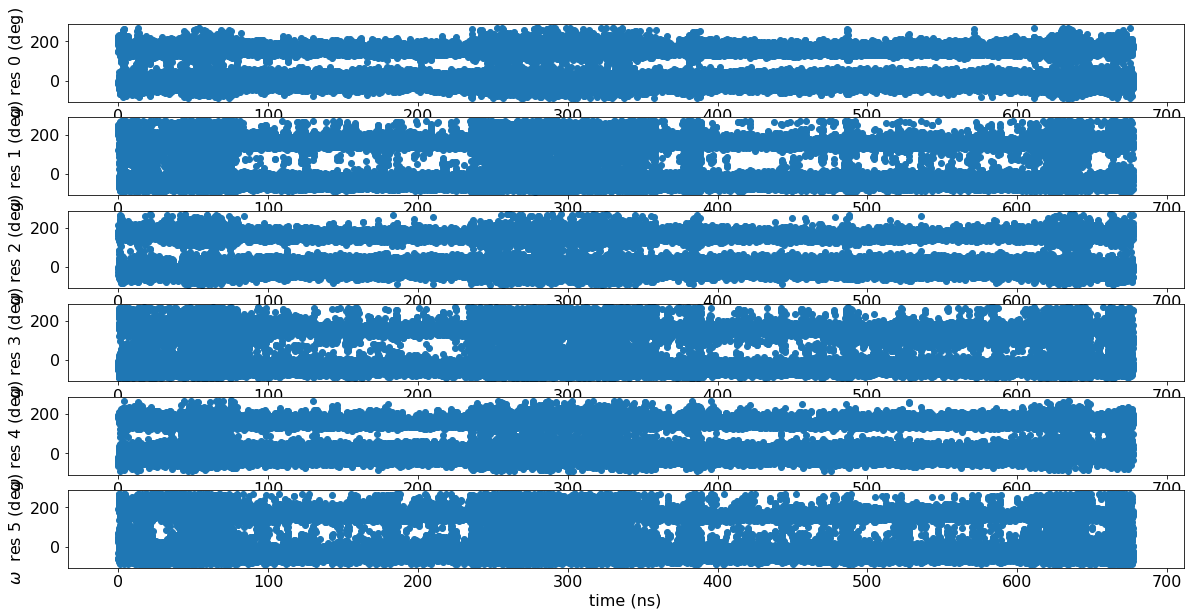

In [4]:
# Load in the omega values, for all temperatures, and organize by replica (not temp)

all_omegas = [] 
for rep in range(36):
    all_omegas.append( np.load("./omegas_H030_traj%d.npy"%rep) )
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print("all_omegas.shape", all_omegas.shape)

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('md0.log_replex.dat')
print("replica_indices.shape", replica_indices.shape)

start = 0
nsnaps = np.shape(all_omegas)[1]
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i,:])
    all_omegas[:,i,:]=all_omegas[Ind,i,:]

# get omega values into the range (-90, 270)
all_omegas = (all_omegas + 90.0)%360.0 - 90.0

# plot omega angles vs time for residue 4, for replica starting at rep=0
plt.figure( figsize=(20,10) )
panel = 0
for residue in range(6):
    panel += 1
    plt.subplot(6,1,panel)
    t = np.arange(start,nsnaps)*0.010  # time axis in ns
    plt.scatter(t,all_omegas[0,start:nsnaps,residue])
    plt.xlabel('time (ns)')
    plt.ylabel('$\\omega$  res %d (deg)'%residue)
plt.show()

In [32]:
import tqdm
def autocorr(x):
    tau = x.size
    mu = x.mean()
    g = np.correlate(x, x, mode='full')[tau-1:]
    g_scaled = [(y-mu**2)/np.var(x) for y in g]
    n = np.arange(tau,0,-1)
    return g_scaled/n

def autocorr_scaled(x):
    tau = x.size
    mu = x.mean()    
    #[<x(t)x(t+tau)> - <x(t)>^2]/<x(t)^2>
    
avg_autocorrel = []  # a list of avergage autocorrelations for each residue
for residue in range(6):
    all_autocorrel = []
    fig, axs = plt.subplots(36, figsize=(20,100))
    ndx = 0
    for replica in tqdm.tqdm(range(36)):
        cis_trans = np.where(all_omegas[replica,:,residue] > 90.0, 1.0, 0.0)
        np.save(f'omega_data/cis_trans_rep_{replica}_res_{residue}.npy',cis_trans)
        axs[ndx].scatter(range(len(cis_trans)),cis_trans, s=8)
        ndx+=1
        #print('residue', residue, 'replica', replica, cis_trans)
        all_autocorrel.append( autocorr(cis_trans) )
    avg_autocorrel.append( np.array(all_autocorrel).mean(axis=0) )
    outfile = 'omega_data/omega_autocorrel_residue%d.npy'%residue
    print('Saving', outfile, '...')
    np.save(outfile, avg_autocorrel[-1])
    fig.tight_layout()
    #plt.show()
    plt.close()



100%|██████████| 36/36 [05:16<00:00,  8.80s/it]


Saving omega_data/_omega_autocorrel_residue0.npy ...



100%|██████████| 36/36 [05:11<00:00,  8.64s/it]


Saving omega_data/_omega_autocorrel_residue1.npy ...



100%|██████████| 36/36 [05:03<00:00,  8.43s/it]


Saving omega_data/_omega_autocorrel_residue2.npy ...



100%|██████████| 36/36 [05:21<00:00,  8.92s/it]


Saving omega_data/_omega_autocorrel_residue3.npy ...



100%|██████████| 36/36 [05:06<00:00,  8.51s/it]


Saving omega_data/_omega_autocorrel_residue4.npy ...



100%|██████████| 36/36 [05:07<00:00,  8.54s/it]


Saving omega_data/_omega_autocorrel_residue5.npy ...


-48432.41312911055
67720
-39447.26173516832
67720
-45981.488995410014
67720
-26181.15404931337
67720
-38891.45804095418
67720
-41821.996123722965
67720


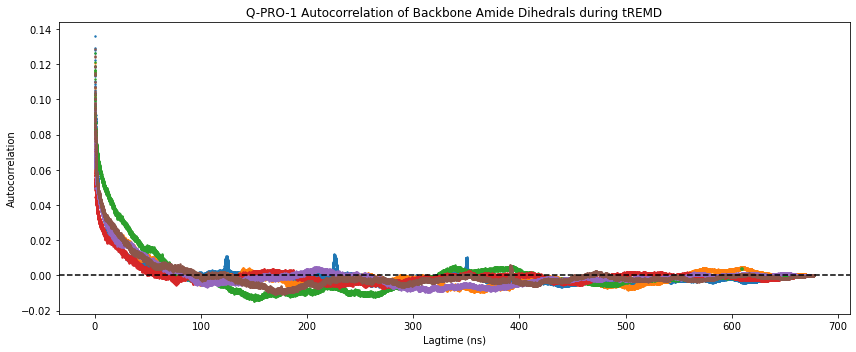

In [28]:
from pandas.plotting import autocorrelation_plot
import numpy as np
import tqdm
from matplotlib import pyplot as plt

if 1: # compute autocorrelation curve and relaxation time for each dihedral
    plt.figure(figsize=(12,5))
    for residue in range(6):
        autocorrelation = np.load(f'omega_data/pandas_autocorr_res_{residue}.npy')
        #print(autocorrelation)
        timesteps = np.arange(0, len(autocorrelation))*0.010
        #ax[residue].scatter(timesteps,autocorrelation, s=2)
        plt.scatter(timesteps,autocorrelation, s=2)
        print(sum([timesteps[x]*autocorrelation[x] for x in range(len(autocorrelation))]) )
            #/sum(autocorrelation))
        print(len(timesteps))
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Autocorrelation')
    plt.title('Q-PRO-1 Autocorrelation of Backbone Amide Dihedrals during tREMD')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.tight_layout()
    plt.savefig('QPM1_Autocorrelation.pdf')
    
if 0: # check histogram of time between cis/trans transitions across tREMD sampling
    counts = []
    for residue in range(6):
        all_autocorrelation = []
        for replica in tqdm.tqdm(range(36)):
            cis_trans = np.load(f'omega_data/cis_trans_rep_{replica}_res_{residue}.npy')
            c = 1
            for x,i in enumerate(cis_trans):
                if x+1 == len(cis_trans):
                    if not c > 1000:
                        counts.append(c)
                    c = 1
                    break
                if cis_trans[x] != cis_trans[x+1]:
                    if not c > 1000:
                        counts.append(c)
                    c = 1
                else:
                    c += 1
            if counts[-1] > 1000:
                print(f'rep{replica-1}-res{residue}: {counts[-1]}')
    plt.hist(counts, bins=1000)
    plt.yscale('log', nonposy='clip')
    plt.xlabel('Timesteps between transitions (10*ps)')
    plt.ylabel('Frequency')
    plt.title('Histogram of cis/trans Transition Frequency')
    plt.show()

In [11]:
    for residue in range(6):
        all_autocorrelation = []
        for replica in tqdm.tqdm(range(36)):
            cis_trans = np.load(f'omega_data/cis_trans_rep_{replica}_res_{residue}.npy')
            print(len(cis_trans)/100)







100%|██████████| 36/36 [00:00<00:00, 1452.01it/s]A






100%|██████████| 36/36 [00:00<00:00, 2133.72it/s]A






100%|██████████| 36/36 [00:00<00:00, 2158.83it/s]A






100%|██████████| 36/36 [00:00<00:00, 1748.98it/s]A






100%|██████████| 36/36 [00:00<00:00, 1510.54it/s]A






100%|██████████| 36/36 [00:00<00:00, 1916.28it/s]A

677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.2
677.

/home/yabmtm/packages/miniconda3/envs/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yabmtm/packages/miniconda3/envs/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yabmtm/packages/miniconda3/envs/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

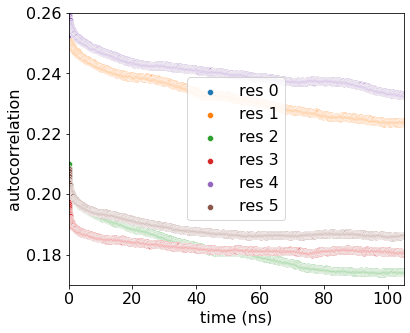

In [6]:
avg_autocorrels = []
plt.figure(figsize=(6,5))
t = np.arange(0, len(cis_trans))*0.010 # frames saved every 10 ps
for residue in range(6):   # the last residue
    infile = 'omega_data/omega_autocorrel_residue%d.npy'%residue
    # print 'Loading', infile, '...'
    avg_autocorrels.append( np.load(infile) )
    plt.scatter(t, avg_autocorrels[-1], label='res %d'%residue)
    plt.xlim(0,105) # only show first part of the autocorrelation curves
    plt.ylim(0.17,0.26) # only show first part of the autocorrelation curves

plt.xlabel('time (ns)')
plt.ylabel('autocorrelation')
#plt.legend(loc='upper right', fontsize=12)

plt.show()



In [16]:
# Fit each autocorrel to get a time constant for each

from scipy.optimize import curve_fit

### Functional forms for fitting ###

def single_exp_decay(x, a0, a1, tau):
    return a0 + a1*np.exp(-(x/tau))

#def single_exp_decay(x, p_trans, tau):
#    return p_trans*(p_trans + (1.-p_trans)*np.exp(-x/tau) )

def double_exp_decay(x, a0, a1, a2, tau1, tau2):
    return a0 + a1*np.exp(-(x/tau1)) + a2*np.exp(-(x/tau2))

### curve-fit and plot the results ###

fit_taus = []

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
for residue in range(0,8):
    
    # for each residue's omega, compute best fit of ac to double-exponential curve
    first_value = avg_autocorrels[residue][0]
    
    v0 = [first_value/2.0,  first_value/2.0, 40.]  # Initial guess [a0, a1, tau] for a0 + a1*exp(-(x/tau))
    popt, pcov = curve_fit(single_exp_decay, t[0:40000], avg_autocorrels[residue][0:40000], p0=v0, maxfev=10000)  # ignore last bin, which has 0 counts
    yFit_data = single_exp_decay(t[0:40000], popt[0], popt[1], popt[2])
    fit_taus.append(popt[2])
    print '--- residue', residue, '---'
    print '### FIT to a0 + a1*exp(-(x/tau1))###'
    print 'best-fit a0 = ', popt[0], '+/-', pcov[0][0]
    print 'best-fit a1 = ', popt[1], '+/-', pcov[1][1]
    print 'best-fit tau = ', popt[2], '+/-', pcov[2][2]

    plt.plot(t[0:40000], avg_autocorrels[residue][0:40000])
    plt.hold(True)
    plt.plot(t[0:40000], yFit_data,  'k--')


plt.xlim(0,400) # only show first part of the autocorrelation curves
plt.ylim(0,0.20) # only show first part of the autocorrelation curves
plt.xlabel('time (ns)')
plt.ylabel('autocorrelation')
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1,2,2)
plt.plot(range(1,9),fit_taus, '*', markersize=10)
plt.xlim(0,9) 
plt.xlabel('residue')
plt.ylabel('autocorrelation time (ns)')

plt.tight_layout()

plt.show()



SyntaxError: Missing parentheses in call to 'print'. Did you mean print('--- residue', residue, '---')? (<ipython-input-16-f1948928cbfb>, line 31)

#rep, #residue, pcis
Loading omega_data/omegas_kang_GMX_allcis_traj0.npy ...
0 0 0.709304844919
0 1 0.970500491658
0 2 0.963967267212
0 3 0.887235212746
0 4 0.623172947118
0 5 0.628039532674
0 6 0.59677338711
0 7 0.785686905218
0 8 0.00569990500158


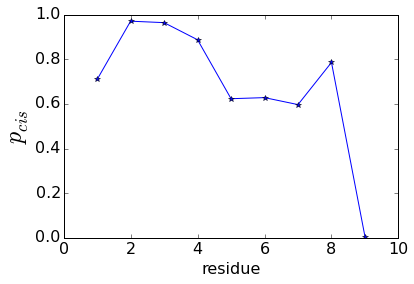

In [5]:
# Load in the last half of the lowest-temperate omega data to estimate cis/trans ratio

mycolors = ['b','r','g','m','y','c','k']
plt.figure()

#plt.figure(figsize=(14,8))
#for rep in range(0,24,4):
for rep in range(0,1):
    pcis = []
    cistrans = []
    print '#rep, #residue, pcis'
    # print omegas
    omegafile = 'omega_data/omegas_kang_GMX_allcis_traj%d.npy'%rep
    print 'Loading', omegafile, '...'
    omegas = np.load(omegafile)
    
    resnums = np.arange(0, 9)
    for i in resnums:
        #print omegas[:,i]
        nomegas = omegas.shape[0]
        Icis = ((omegas[(nomegas/2):,i] < 90.0)*(omegas[(nomegas/2):,i] > -90.0)).astype(float)
        #print Icis
        pcis.append( (Icis.astype(float)).sum()/np.ones(omegas[(nomegas/2):,i].shape).sum() )
        cistrans.append( pcis[-1]/(1.0-pcis[-1]) )
        print rep, i, pcis[-1]
        
    #num_plots = 23
    #colormap = plt.cm.cool
    #plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    #plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
    #plot = plt.plot(cistrans)
    #plt.setp(plot, label= '%d'%rep)
    plt.plot(resnums+1, pcis, mycolors[rep%len(mycolors)]+'*-', label='replica %d'%rep)
    plt.xlim(0,10)
    plt.xlabel('residue')
    plt.ylabel('$p_{cis}$', fontsize=24)
#plt.legend(loc='best')
plt.show()

In [47]:
# calculate phi angles for each replica
phi_dihedral_indices = np.array([
        [  4,   6,  21, 23],
        [ 23,  29,  44, 46],
        [ 46,  52,  67, 69],
        [ 69,  125,  128, 130],
        [ 130,  174, 189, 191],
        [191, 197, 212, 214],
        [214, 270, 273, 275],
        [275, 319, 334, 336],
        [336, 342, 357, 359]])


for rep in range(0, 24):
    xtcfile = os.path.join(workdir,'traj%d.xtc'%rep)
    pdbfile = os.path.join(workdir,'kang_GMX_allcis.pdb')
    traj = md.load(xtcfile, top=pdbfile)
    phis = md.compute_dihedrals(traj, phi_dihedral_indices)*(180.0/math.pi)
    # print phis
    outfile = 'phi_data/phis_kang_GMX_allcis_traj%d.npy'%rep
    print 'Saving', outfile, '...'
    np.save(outfile, phis)

Saving phi_data/phis_kang_GMX_allcis_traj0.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj1.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj2.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj3.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj4.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj5.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj6.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj7.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj8.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj9.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj10.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj11.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj12.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj13.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj14.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj15.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj16.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj17.npy ...
Saving phi_data/phis_kang_GMX_allcis_traj18.npy ...
Saving phi_data/phis_k

#res helix
0 0.708504858252
1 0.958334027766
2 0.949600839986
3 0.833169447176
4 0.616973050449
5 0.628039532674
6 0.595506741554
7 0.534524424593
8 0.00523324611256
Average cis content: 0.685597832629
Average helix content: 0.64776512984


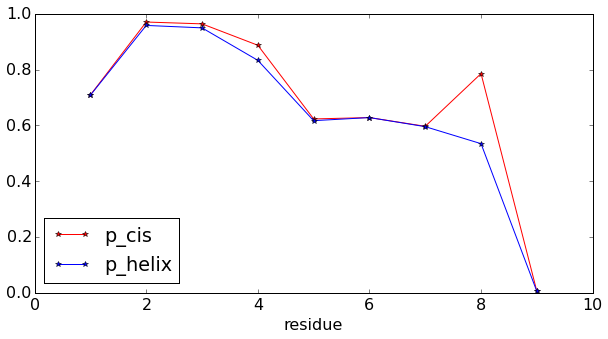

In [7]:
# Load in the last half of the lowest-temperate omega and phi data to estimate c- (helix) population vs. chain length
rep = 0

# read in the last half of the omegas
omegafile = 'omega_data/omegas_kang_GMX_allcis_traj%d.npy'%rep
omegas = np.load(omegafile)
nomegas = omegas.shape[0]
omegas = omegas[(nomegas/2):,:]

# read in the last half of the phis
phifile = 'phi_data/phis_kang_GMX_allcis_traj%d.npy'%rep
phis = np.load(phifile)
nphis = phis.shape[0]
phis = phis[(nphis/2):,:]


phelix = []


print '#res helix'
plt.figure(figsize=(10,5))
for residue in range(0,9):
        
    Icis = ((omegas[:,residue] < 90.0)*(omegas[:,residue] > -90.0)).astype(float)
    Iphiminus = (phis[:,residue] < 0.0).astype(float)
    Ihelix = Icis*Iphiminus
    p = Ihelix.sum()/np.ones(Ihelix.shape).sum()
    phelix.append( p )
    print residue, p     

print 'Average cis content:', np.array(pcis).mean()
print 'Average helix content:', np.array(phelix).mean()


plt.plot(range(1,10), pcis, 'r*-', label='p_cis')
plt.plot(range(1,10), phelix, 'b*-', label="p_helix")
plt.xlabel('residue')
plt.xlim(0,10)
plt.legend(loc='best')
plt.show()

In [ ]:
# Plot rmsd vs time
plt.figure(figsize=(10,5),dpi=300)
#all_contacts = [ np.sum(contacts[0][frame]) for frame in range(0, len(contacts[0])) ] 
ns = np.arange(0, len(rmsds)) / 10 # frames saved every 100 ps
plt.plot(ns, rmsds*10, 'r.')
plt.plot(ns, pd.rolling_mean(rmsds,100)*10, 'k-')
plt.xlabel('Simulation Time (ns)')
plt.ylabel('RMSD in $\AA$ ')
plt.show()

In [ ]:
# Ramachandran plot
plt.figure(figsize=(10,5),dpi=300)
plt.hist2d((np.fmod(phis[1]*(180/math.pi)+360, 360).flatten()),
           (np.fmod(psis[1]*(180/math.pi)+360, 360).flatten()), 
           cmin=1, bins=180, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlim(0,360)
plt.ylim(0,360)
plt.ylabel('$\Psi$ (degrees)')
plt.xlabel('$\Phi$ (degrees)')
plt.savefig('rama_%dmer.svg'%nmer)
plt.show()

In [ ]:
plt.gcf().canvas.get_supported_filetypes()

In [ ]:
plt.figure()
plt.plot([ord(dssp[i][1]) for i in range(len(dssp))],'ko')